# Model Training

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [5]:
df = pd.read_csv('../data/prepared/df_prepared.csv')
df = df.set_index('time')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34896 entries, 2015-01-07 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 41 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation fossil brown coal/lignite         34896 non-null  float64
 1   generation fossil gas                        34896 non-null  float64
 2   generation fossil hard coal                  34896 non-null  float64
 3   generation fossil oil                        34896 non-null  float64
 4   generation hydro pumped storage consumption  34896 non-null  float64
 5   generation hydro water reservoir             34896 non-null  float64
 6   generation other renewable                   34896 non-null  float64
 7   generation solar                             34896 non-null  float64
 8   total load actual                            34896 non-null  float64
 9   price day ahead                  

In [6]:
X, y = df.drop('total load actual', axis=1), df['total load actual']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


print(X.shape)
print(y.shape)
print(y_train.isna().sum())
print(y_test.isna().sum())

(34896, 40)
(34896,)
0
0


## Random Forest

In [7]:
# Hyperparameter tuning using Grid Search

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid,
                              scoring='neg_mean_absolute_error', cv=3, verbose=1)

grid_search_rf.fit(X_train, y_train)

print("Best parameters:", grid_search_rf.best_params_)
best_rf = grid_search_rf.best_estimator_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'max_depth': None, 'n_estimators': 200}


## XGBoost

In [8]:
# Hyperparameter tuning using Random Search

param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 10]
}

random_search_xgb = RandomizedSearchCV(
    xgb.XGBRegressor(), param_distributions=param_dist,
    scoring='neg_mean_absolute_error', cv=3, n_iter=10, verbose=1
)
random_search_xgb.fit(X_train, y_train)

print("Best parameters:", random_search_xgb.best_params_)
best_xgb = random_search_xgb.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}


## Metrics 

In [9]:
# Predict using best models trained

y_pred_rf_best = best_rf.predict(X_test)
y_pred_xgb_best = best_xgb.predict(X_test)

# Metrics
metrics = {
    'Model': ['Random Forest', 'XGBoost'],
    'MAE': [
        mean_absolute_error(y_test, y_pred_rf_best),
        mean_absolute_error(y_test, y_pred_xgb_best)
    ],
    'MAPE': [
        mean_absolute_percentage_error(y_test, y_pred_rf_best) * 100,
        mean_absolute_percentage_error(y_test, y_pred_xgb_best) * 100
    ],
    'R²': [
        r2_score(y_test, y_pred_rf_best),
        r2_score(y_test, y_pred_xgb_best)
    ]
}

In [10]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,MAE,MAPE,R²
0,Random Forest,799.001024,2.832445,0.936042
1,XGBoost,636.752468,2.253507,0.963927


C:\Users\canil\AppData\Local\Temp\ipykernel_14236\272902529.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Model', y='MAE', data=metrics_df, palette='Blues_d')
C:\Users\canil\AppData\Local\Temp\ipykernel_14236\272902529.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Model', y='MAPE', data=metrics_df, palette='Greens_d')
C:\Users\canil\AppData\Local\Temp\ipykernel_14236\272902529.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x='Model', y='R²', data=metrics_df, palette='flare')


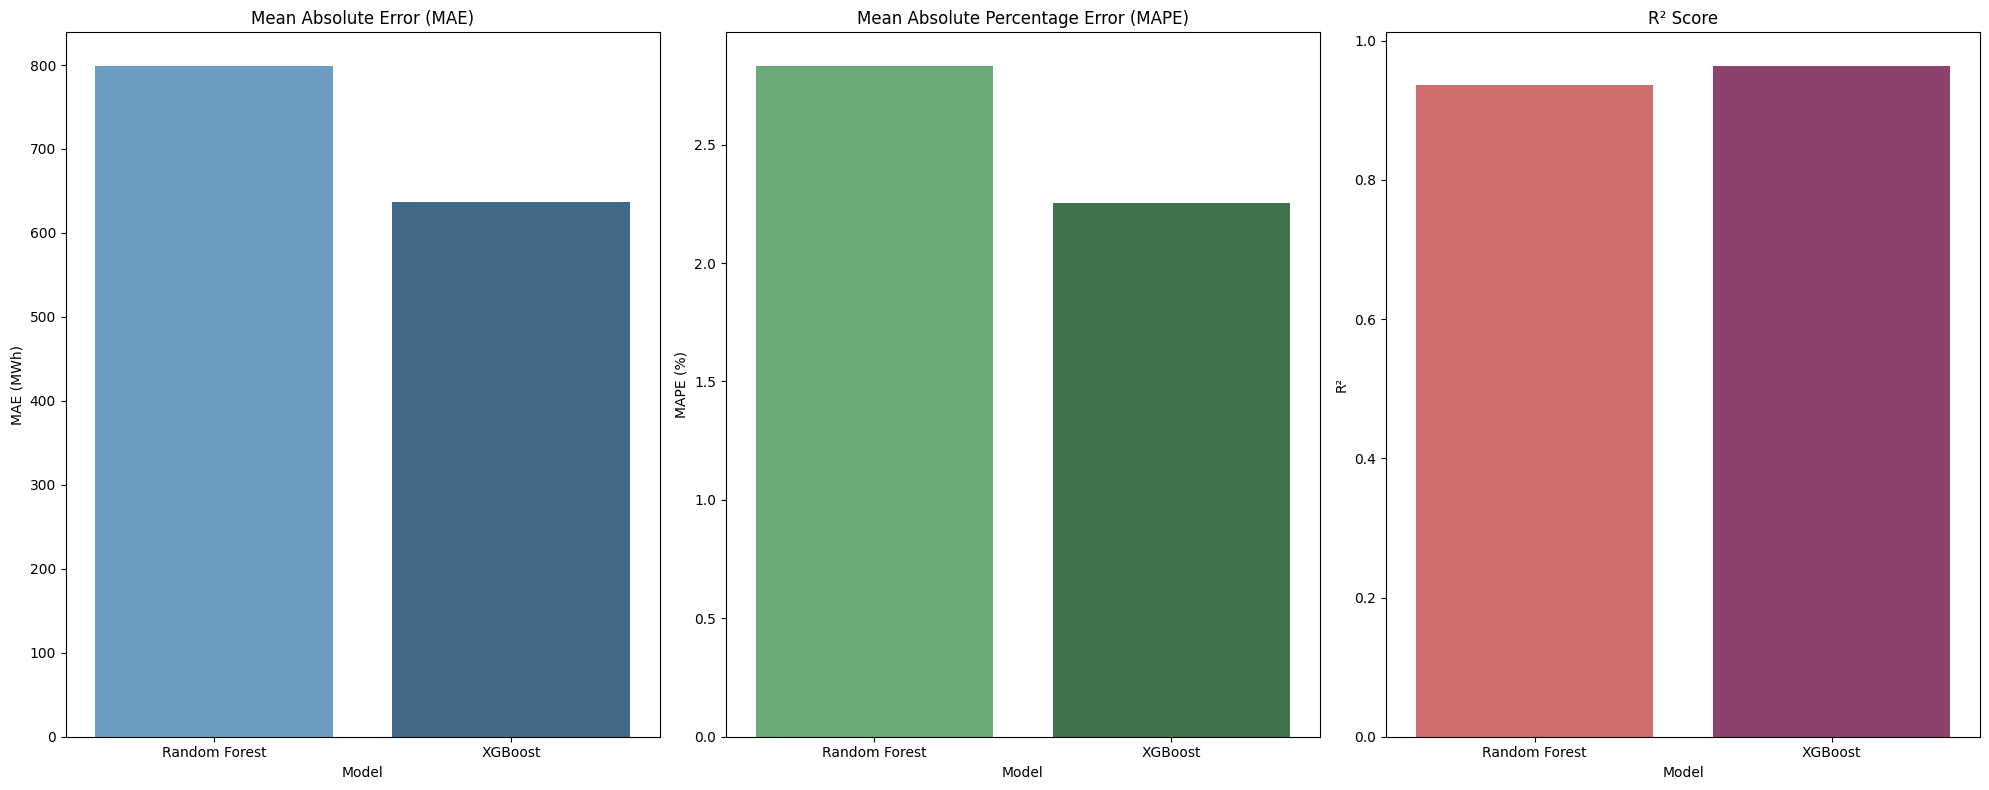

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

sns.barplot(ax=axes[0], x='Model', y='MAE', data=metrics_df, palette='Blues_d')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE (MWh)')

sns.barplot(ax=axes[1], x='Model', y='MAPE', data=metrics_df, palette='Greens_d')
axes[1].set_title('Mean Absolute Percentage Error (MAPE)')
axes[1].set_ylabel('MAPE (%)')

sns.barplot(ax=axes[2], x='Model', y='R²', data=metrics_df, palette='flare')
axes[2].set_title('R² Score')
axes[2].set_ylabel('R²')

plt.tight_layout()
plt.show()

In [12]:
importances_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

importances_rf.head(5).round(3)

,Feature,Importance
31,hour,0.464
3,generation fossil oil,0.166
38,load_lag_24h,0.116
4,generation hydro pumped storage consumption,0.055
1,generation fossil gas,0.043


In [13]:
importances_xgb = pd.DataFrame({
    'Feature': best_xgb.feature_names_in_,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

importances_xgb.head(5).round(3)


,Feature,Importance
31,hour,0.346
4,generation hydro pumped storage consumption,0.250
38,load_lag_24h,0.081
3,generation fossil oil,0.072
1,generation fossil gas,0.031


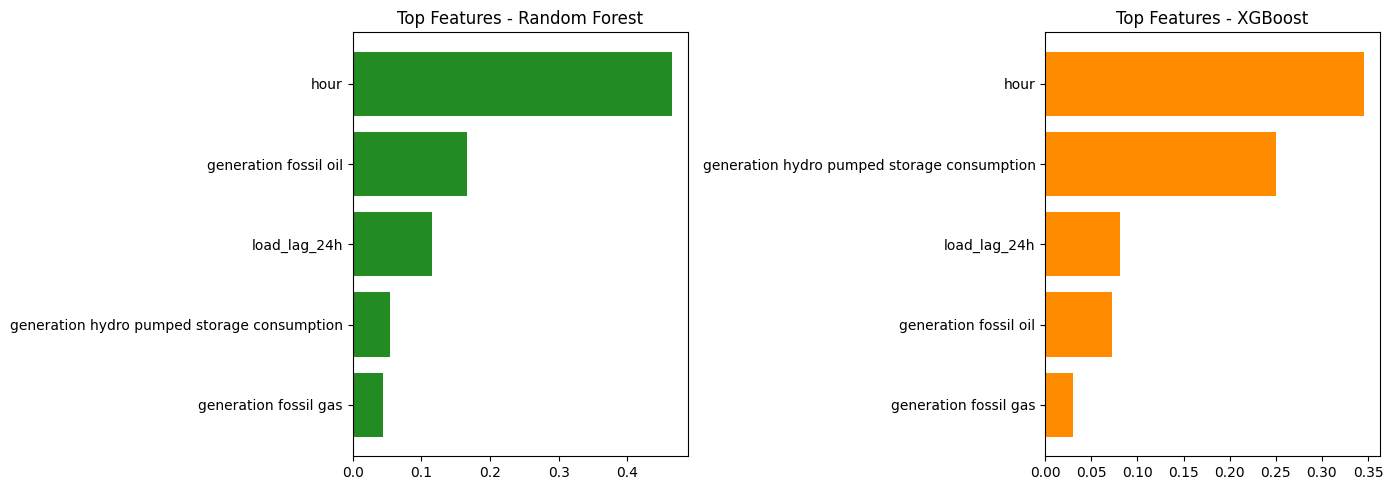

In [14]:
top_rf = importances_rf.head(5)
top_xgb = importances_xgb.head(5)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest plot
axs[0].barh(top_rf['Feature'], top_rf['Importance'], color='forestgreen')
axs[0].set_title('Top Features - Random Forest')
axs[0].invert_yaxis()

# XGBoost plot
axs[1].barh(top_xgb['Feature'], top_xgb['Importance'], color='darkorange')
axs[1].set_title('Top Features - XGBoost')
axs[1].invert_yaxis()

plt.tight_layout()
plt.show()